In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv


In [2]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor


Using TensorFlow backend.


#  Processing the dataset

In [3]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv') 
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
target = train.SalePrice
train.drop(['SalePrice'],axis = 1 , inplace = True)

combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop(['index', 'Id'], inplace=True, axis=1)

In [5]:
combined.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [6]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [7]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

In [8]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 25
Number of nun-numerical columns with no nan values : 20


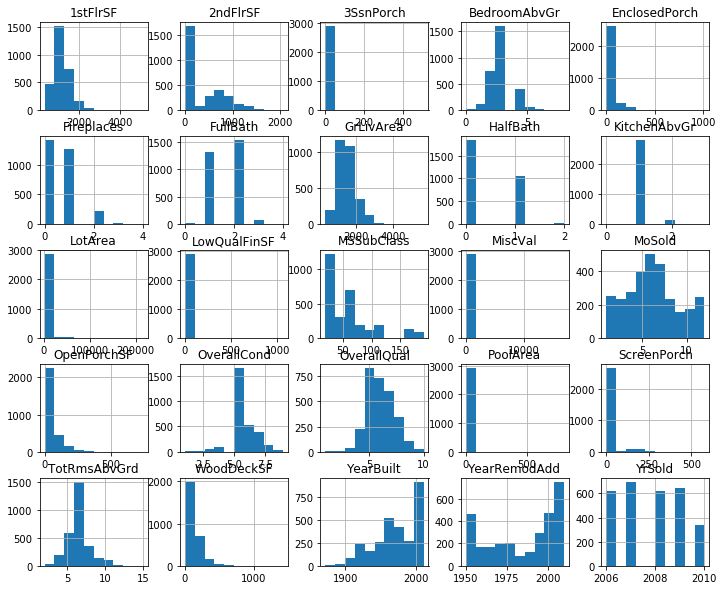

In [9]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

# The correlation between the features

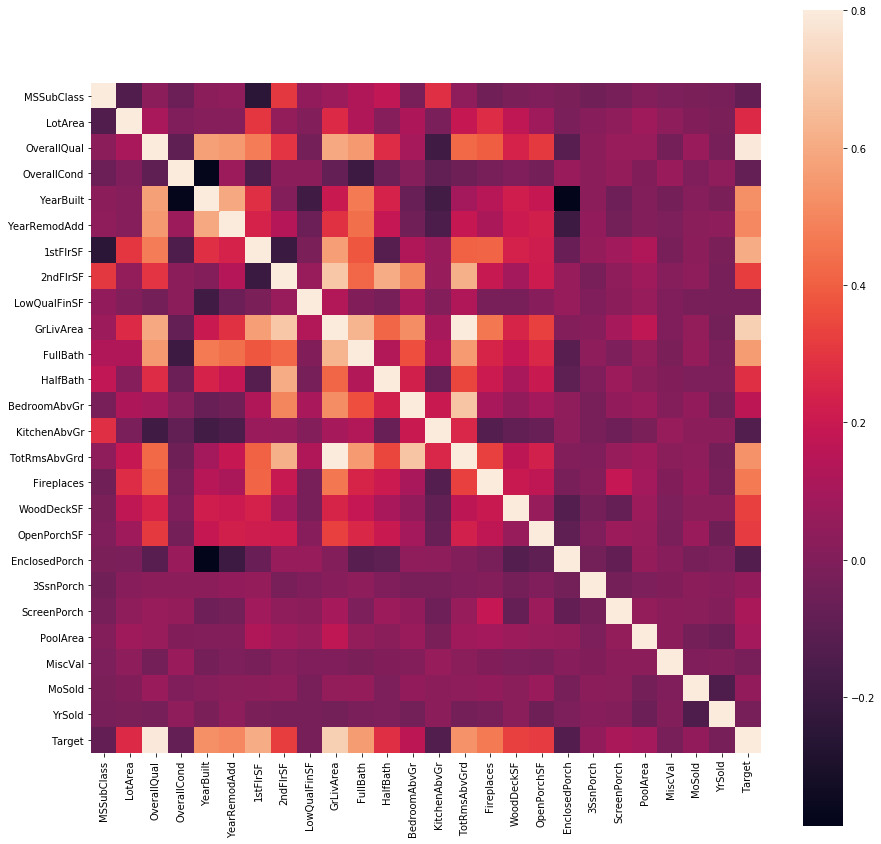

In [10]:
train = train[num_cols + cat_cols]
train['Target'] = target

C_mat = train.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

we can see that 15 features are highly correlated with the target.****

# One Hot Encoding :

In [11]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 45 columns before encoding categorical features
There are 149 columns after encoding categorical features


In [12]:
def split_combined():
    global combined
    train = combined[:1460]
    test = combined[1460:]

    return train , test 
  
train_data, test_data = split_combined()

# Making Neural Network

In [13]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train_data.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               19200     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 184,065
Trainable params: 184,065
Non-trainable params: 0
_________________________________________________________________


In [14]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

### Training the model

In [15]:
NN_model.fit(train_data, target, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 1168 samples, validate on 292 samples
Epoch 1/500
1168/1168 [==============================] - 1s 477us/step - loss: 132568.4609 - mean_absolute_error: 132568.4375 - val_loss: 53458.3797 - val_mean_absolute_error: 53458.3789

Epoch 00001: val_loss improved from inf to 53458.37966, saving model to Weights-001--53458.37966.hdf5
Epoch 2/500
1168/1168 [==============================] - 0s 108us/step - loss: 54360.6513 - mean_absolute_error: 54360.6523 - val_loss: 47790.5418 - val_mean_absolute_error: 47790.5430

Epoch 00002: val_loss improved from 53458.37966 to 47790.54185, saving model to Weights-002--47790.54185.hdf5
Epoch 3/500
1168/1168 [==============================] - 0s 127us/step - loss: 46009.2245 - mean_absolute_error: 46009.2266 - val_loss: 44836.8314 - val_mean_absolute_error: 44836.8320

Epoch 00003: val_loss improved from 47790.54185 to 44836.83144, saving model to Weights-003--44836.83144.hdf5
Epoch 4/500
1168/1168 [==============================] - 0s 106us/step 

In [16]:
# Load wights file of the best model :
# wights_file = 'Weights-397--18993.77574.hdf5' # choose the best checkpoint 
# NN_model.load_weights(wights_file) # load it
# NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

We see that the validation loss of the best model is 18722.41128

In [17]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'Id':test.Id,'SalePrice':prediction})
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  print('A submission file has been made')

predictions = NN_model.predict(test_data)
make_submission(predictions[:,0],'submission(NN).csv')

A submission file has been made


# Random Forest 

spiltting:

In [18]:
train_X, val_X, train_y, val_y = train_test_split(train_data, target, test_size = 0.25, random_state = 14)

In [19]:
model = RandomForestRegressor()
model.fit(train_X,train_y)

# Get the mean absolute error on the validation data
predicted_prices = model.predict(val_X)
MAE = mean_absolute_error(val_y , predicted_prices)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  18023.049388127853


In [20]:
predicted_prices = model.predict(test_data)
make_submission(predicted_prices,'Submission(RF).csv')

A submission file has been made


# XGBoost model :

In [21]:
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)

XGBoost validation MAE =  19944.331282106163


In [22]:

XGBpredictions = XGBModel.predict(test_data)
make_submission(XGBpredictions,'Submission(XGB).csv')

A submission file has been made


# LGBM 

In [23]:
from lightgbm import LGBMRegressor
LGBM = LGBMRegressor(n_estimators = 1000)
LGBM.fit(train_X,train_y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [24]:
LGBMpredictions = LGBM.predict(val_X)
MAE = mean_absolute_error(val_y , LGBMpredictions)
print('LGBM validation MAE = ',MAE)

LGBM validation MAE =  19043.26103999334


In [25]:

LGBMpredictions = LGBM.predict(test_data)
make_submission(LGBMpredictions,'Submission(LGBM).csv')

A submission file has been made


> References:(https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/)